In [1]:
import os
import datetime

from io import BytesIO

import matplotlib.pyplot as plt
import modal
import numpy as np
from PIL import Image
import supervision as sv
import cv2

In [55]:
def visualize_and_save_annotations(
    image_pil, 
    segmentation_results, 
    show_plot=True
):
    if segmentation_results[0]["labels"] == []:
        print("No segmentation results found.")
        return None
    # Extract data from segmentation_results
    boxes = segmentation_results[0]['boxes']
    scores = segmentation_results[0]['scores']
    labels = segmentation_results[0]['labels']
    

    # Create class_id for each unique label
    print("labels found:", labels)
    unique_labels = list(set(labels))
    print("unique labels found:", unique_labels)
    class_id_map = {label: idx for idx, label in enumerate(unique_labels)}
    print("class_id_map:", class_id_map)
    class_id = np.array([class_id_map[label] for label in labels])
    print("class_id:", class_id)

    # Format labels to include confidence scores
    formatted_labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

    # Convert to supervision's detection format
    detections = sv.Detections(
        xyxy=boxes,
        confidence=scores,
        class_id=class_id
    )
    
    # Create annotators
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    
    # Create a copy of the original image for annotation
    image_rgb = np.array(image_pil)
    annotated_image = image_rgb.copy()
    
    # Apply annotations
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections, labels=formatted_labels
    )
    
    # Display images side by side if requested
    if show_plot:
        plt.figure(figsize=(16, 8))
        
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title(f"Detected {labels}")
        plt.imshow(annotated_image)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


In [ ]:
def visualize_clip_predictions(image_pil, predictions, show=True, save_path=None):
    """
    Visualize bounding boxes from CLIP predictions on an image.
    
    Args:
        image_pil (PIL.Image): The original input image
        predictions (list): List of prediction dictionaries with 'label', 'score', and 'box' keys
        show (bool): Whether to display the image with matplotlib
        save_path (str, optional): Path to save the annotated image
        
    Returns:
        PIL.Image: The annotated image
    """
    import matplotlib.pyplot as plt
    from PIL import Image, ImageDraw, ImageFont
    
    # Make a copy of the image to avoid modifying the original
    image_copy = image_pil.copy()
    draw = ImageDraw.Draw(image_copy)
    
    # Define colors for different predictions (cycling through these)
    colors = ["red", "green", "blue", "yellow", "purple", "cyan", "orange"]
    
    for i, prediction in enumerate(predictions):
        # Extract data from prediction
        box = prediction["box"]
        label = prediction["label"]
        score = prediction["score"]
        
        # Get color for this prediction
        color = colors[i % len(colors)]
        
        # Draw rectangle
        xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
        draw.rectangle((xmin, ymin, xmax, ymax), outline=color, width=3)
        
        # Draw label with score
        label_text = f"{label}: {score:.2f}"
        draw.text((xmin, ymin-15), label_text, fill=color)
    
    # Display image if requested
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(image_copy)
        plt.axis('off')
        plt.title(f"Detected {len(predictions)} objects")
        plt.show()
    
    # Save image if path provided
    if save_path:
        image_copy.save(save_path)
    
    return image_copy

In [3]:
input_dir = "../src/assets/examples"
output_dir = "./output"
img_name = "test_5.jpg"
os.makedirs(output_dir, exist_ok=True)
image_pil = Image.open(f"{input_dir}/{img_name}").convert("RGB")


In [62]:
zeroshot_modal = modal.Function.from_name("zeroshot-test", "zeroshot_modal")
clip=modal.Function.from_name("zeroshot-test", "clip")
sam2=modal.Function.from_name("zeroshot-test", "sam2")

In [50]:
prompt = ["white shirt of woman","cup on the table","pants on the table"]

In [60]:
result = clip.remote(image_pil, prompt)
result

[{'label': 'white shirt of woman',
  'score': 0.8401402831077576,
  'box': {'xmin': 857, 'ymin': 439, 'xmax': 1220, 'ymax': 965}},
 {'label': 'cup on the table',
  'score': 0.7145085334777832,
  'box': {'xmin': 857, 'ymin': 1109, 'xmax': 1021, 'ymax': 1290}}]

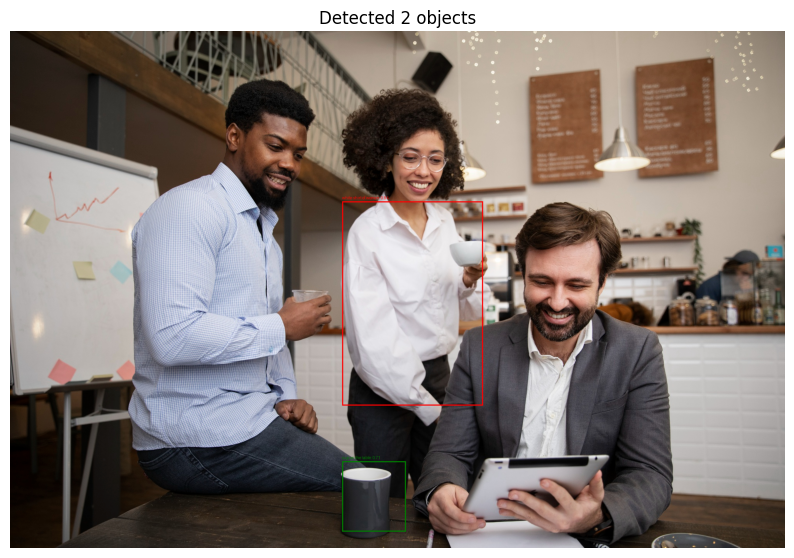

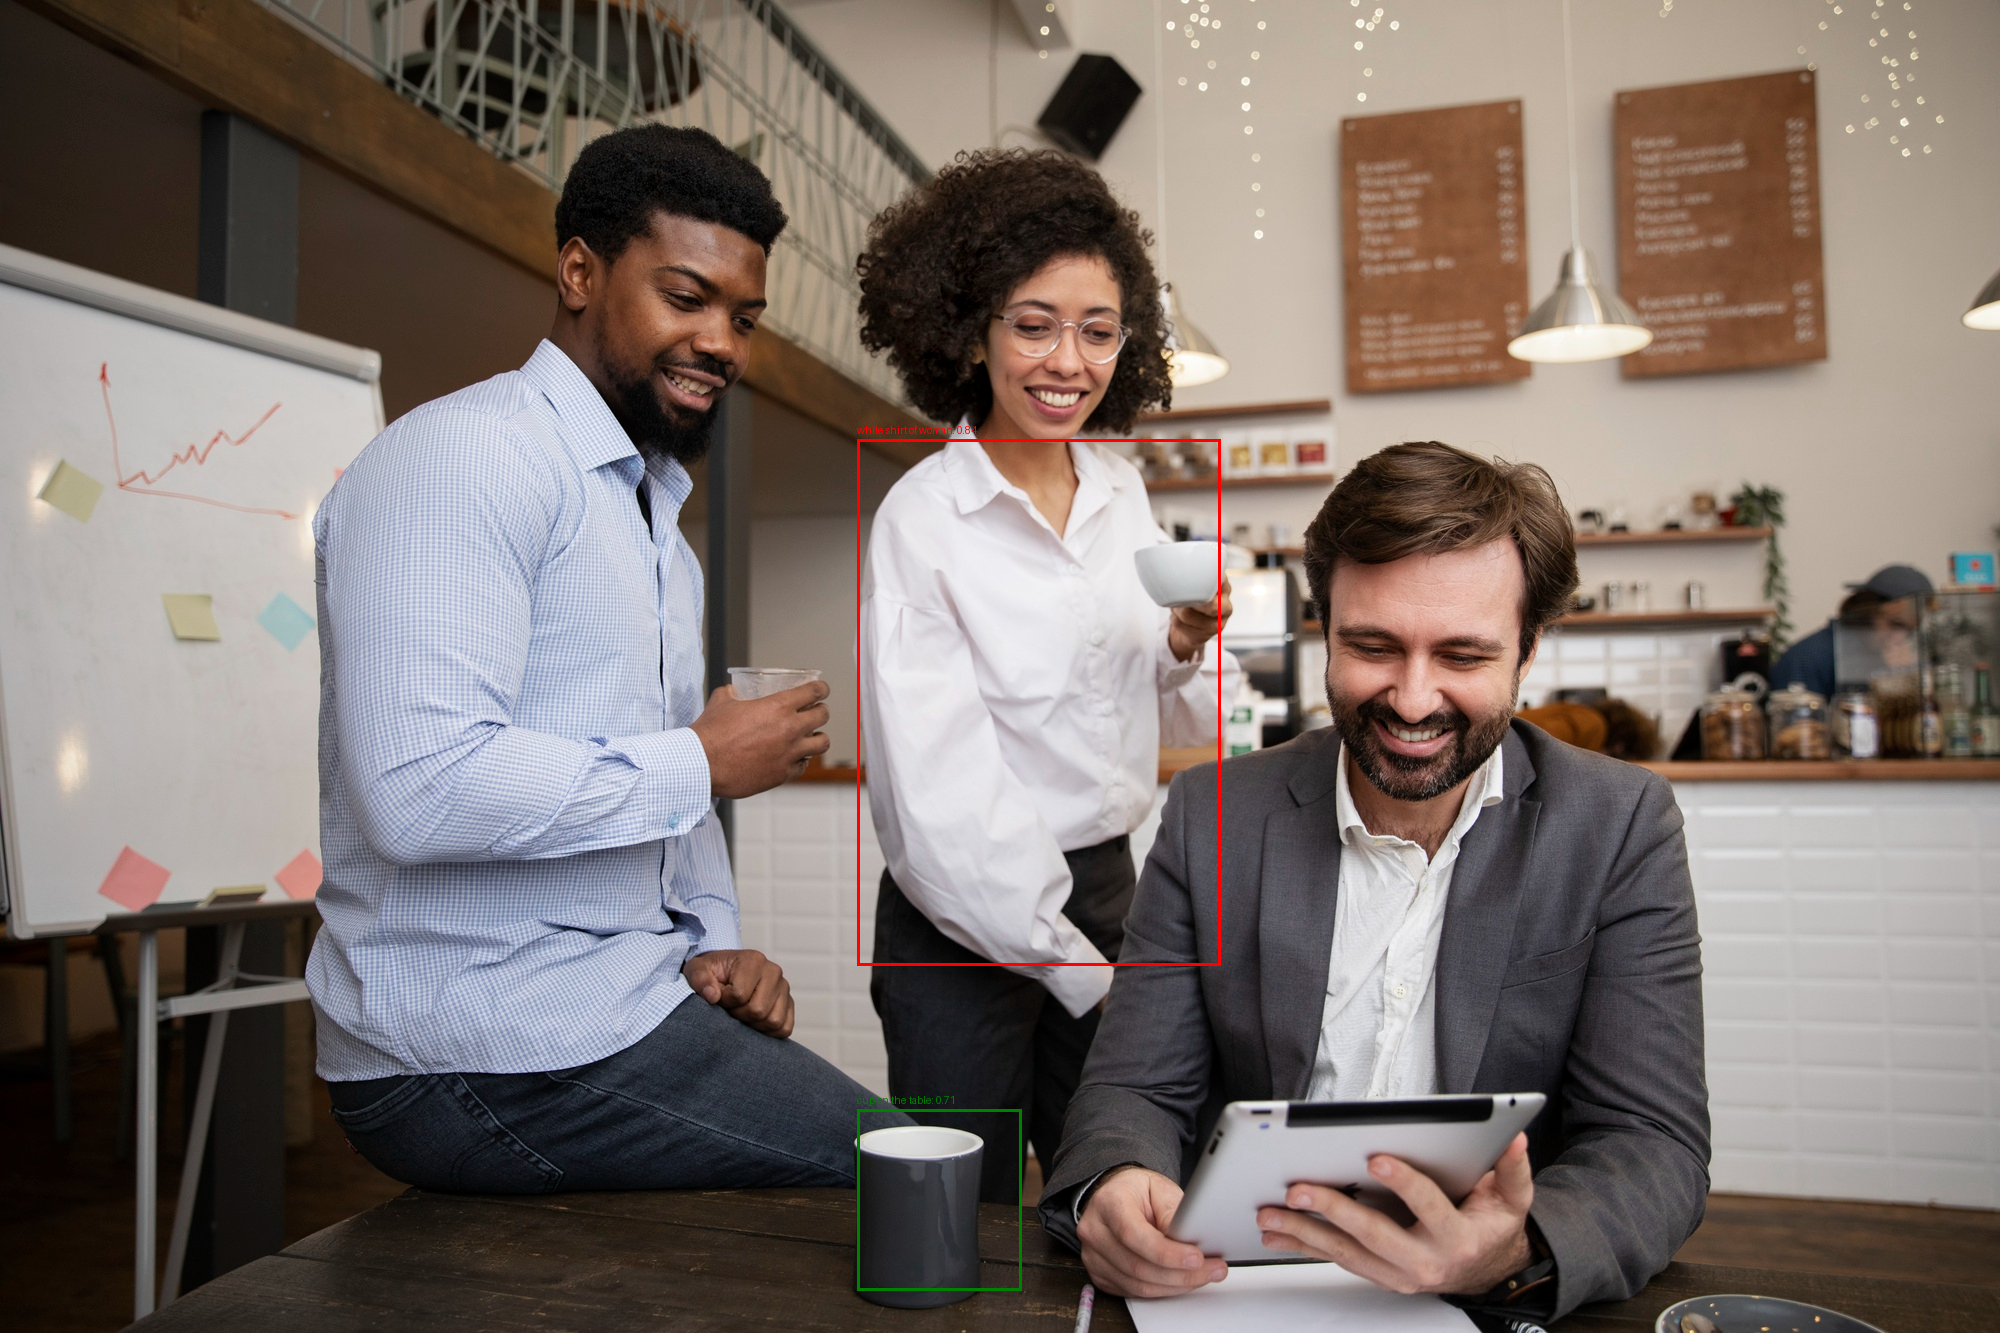

In [61]:
visualize_clip_predictions(image_pil, result, show=True, save_path=f"{output_dir}/clip_predictions_{img_name}")

In [72]:
boxes = np.array([np.array(list(result[i]["box"].values())) for i in range(len(result))])
boxes

array([[ 857,  439, 1220,  965],
       [ 857, 1109, 1021, 1290]])

In [73]:
sam2_result = sam2.remote(image_pil, boxes)

In [74]:
sam2_result

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]],
       shape=(2, 1, 1333, 2000), dtype=float32),
 array([[0.96875  ],
        [0.9921875]], dtype=float32))